In [2]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np

from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# 704 samples produced. Input is the y values of the signal
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x1_bn1 = nn.BatchNorm1d(32)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x1_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x1_bn2 = nn.BatchNorm1d(64)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x1_bn3 = nn.BatchNorm1d(16)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x1_bn4 = nn.BatchNorm1d(1)
        self.x1_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Probe 2
        self.x2_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x2_bn1 = nn.BatchNorm1d(32)
        self.x2_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        
        self.x2_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x2_bn2 = nn.BatchNorm1d(64)
        self.x2_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x2_bn3 = nn.BatchNorm1d(16)
        self.x2_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x2_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x2_bn4 = nn.BatchNorm1d(1)
        self.x2_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(14, out_features=6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x1 = self.x1_pool1(
            self.x1_bn1(
                torch.relu(self.x1_conv1(x[:, 0].reshape(-1, 1, 128)))
            )
        )
        
        x1 = self.x1_pool2(
            self.x1_bn2(torch.relu(self.x1_conv2(x1)))
        )
        
        x1 = self.x1_pool3(
            self.x1_bn3(torch.relu(self.x1_conv3(x1)))
        )
        
        x1 = self.x1_pool4(
            self.x1_bn4(torch.relu(self.x1_conv4(x1)))
        )
        
        x2 = self.x2_pool1(
            self.x2_bn1(torch.relu(self.x2_conv1(x[:, 1].reshape(-1, 1, 128))))
        )
        
        x2 = self.x2_pool2(
            self.x2_bn2(torch.relu(self.x2_conv2(x2)))
        )
        
        x2 = self.x2_pool3(
            self.x2_bn3(torch.relu(self.x2_conv3(x2)))
        )
        
        x2 = self.x2_pool4(
            self.x2_bn4(torch.relu(self.x2_conv4(x2)))
        )
        #x1 = x1.view(batch_size, 6)
        #x2 = x2.view(batch_size, 6)
        x = torch.cat((x1, x2), dim=2).reshape(batch_size, 14)
        #print(x.shape, x1.shape, x2.shape)
        x = self.fc1(x)
        return x
                            
                            
def train(train_loader, net, LR=0.5, epochs=256):
    net.to(DEVICE)
    net.train()
    
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.MSELoss()
    all_MSE = nn.MSELoss()
    print(f"Using: {DEVICE}")
                            
    parameter_loss = []
    losses = []
    processed = 0
    last_loss = 0
    for epoch in range(epochs):
        loss = 0
        
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss)
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
                
                for i in range(len(predicted)):
                    current_MSE = []
                    for j in range(6):
                        current_MSE.append(all_MSE(out[i][j], predicted[i][j]).item())
                    parameter_loss.append(current_MSE)
                    processed += 1
                    
                
                
        
        losses.append(loss)
        last_loss = loss/len(it)
    print("Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm")
    print(f"Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10") 
    print(f"Average parameter loss: {np.mean(np.reshape(np.array(parameter_loss), (-1, 6)), axis=0)}")        
    print(f"Average overall loss: {np.sum(losses)/processed}")        

def test(test_loader, net):
    net.to(DEVICE)
    net.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():
            loss = 0
            with tqdm(test_loader, unit=" batch") as it:
                for idx, data in enumerate(it):
                    inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                    
                    predicted = net(inp)
                    cost = criterion(out, predicted)
                    l_t = cost.item()
                    loss += l_t
                    
                    #print(f"\n\n\nBatch: {idx}")
                   # print(f"loss: {l_t}")
                    #for i, target in enumerate(out):
                   #     errs = []
                   #     print(f"Targer: {target}, \npredicted: {predicted[i]}\n\n")
                   #     for j in range(len(predicted)):
                   #         errs.append(abs(predicted[i]-target[i])**2)
                   #     print(f"MSE: {np.mean(errs[0])}")
            
            print(f"Average Loss: {loss/len(it)}") 
            
torch.backends.cudnn.benchmark = True

In [4]:
np.array([[[1, 2], [3, 4]], [[3, 4], [3, 5]]]).reshape(-1, 2)

array([[1, 2],
       [3, 4],
       [3, 4],
       [3, 5]])

# For 100
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        self.x1_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.x1_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.x1_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x1_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Probe 2
        self.x2_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.x2_pool1 = nn.MaxPool1d(kernel_size=6, stride=2)
        self.x2_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.x2_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.x2_conv3 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.x2_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.x2_conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.x2_pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(4, out_features=6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x1 = self.x1_pool1(torch.relu(self.x1_conv1(x[:, 0].reshape(-1, 1, 50))))
        x1 = self.x1_pool2(torch.relu(self.x1_conv2(x1)))
        x1 = self.x1_pool3(torch.relu(self.x1_conv3(x1)))
        x1 = self.x1_pool4(torch.relu(self.x1_conv4(x1)))
        
        x2 = self.x2_pool1(torch.relu(self.x2_conv1(x[:, 1].reshape(-1, 1, 50))))
        x2 = self.x2_pool2(torch.relu(self.x2_conv2(x2)))
        x2 = self.x2_pool3(torch.relu(self.x2_conv3(x2)))
        x2 = self.x2_pool4(torch.relu(self.x2_conv4(x2)))
        
        #x1 = x1.view(batch_size, 6)
        #x2 = x2.view(batch_size, 6)
        x = torch.cat((x1, x2), dim=2).reshape(batch_size, 4)
        #print(x.shape, x1.shape, x2.shape)
        x = self.fc1(x)
        return x

In [5]:
def checkSubsets(signalFolder, sampleFile, splits=4):
    with open(f"{sampleFile}", "rb") as f:
        samples = pickle.load(f).astype(np.float32)
        
    runs = 0
    exps = os.listdir(f"{signalFolder}/")
    exps = [int(exp) for exp in exps]
    
    split_step = len(exps)//splits
    
    fig = plt.figure(constrained_layout=True, figsize=(15, 10*splits))
    intervals = fig.subfigures(nrows=splits, ncols=1)
    
    for i in range(splits):
        lower_idx = i*split_step
        upper_idx = ((i+1)*split_step)-1 if i != splits-1 else len(exps)-1
        mid_idx = (lower_idx + upper_idx) // 2
        
        intervals[i].suptitle(f"Curves in interval [{lower_idx}, {upper_idx}]")
        probes = intervals[i].subfigures(nrows=2, ncols=1)
        
        
        for probe, file in enumerate(['Disp1.csv', 'Disp2.csv']):
            probes[probe].suptitle(f"Probe {probe}")
            curves = probes[probe].subplots(nrows=1, ncols=3)
            
            for curve, idx in enumerate([lower_idx, mid_idx, upper_idx]):
                a = pd.read_csv(f"{signalFolder}/{idx}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                title = "First" if curve == 0 else "Midpoint" if curve == 1 else "Last"
                curves[curve].set_title(title)
                a.plot(ax=curves[curve], x='x', y='y')

In [6]:
checkSubsets("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl", splits=20)

NameError: name 'pickle' is not defined

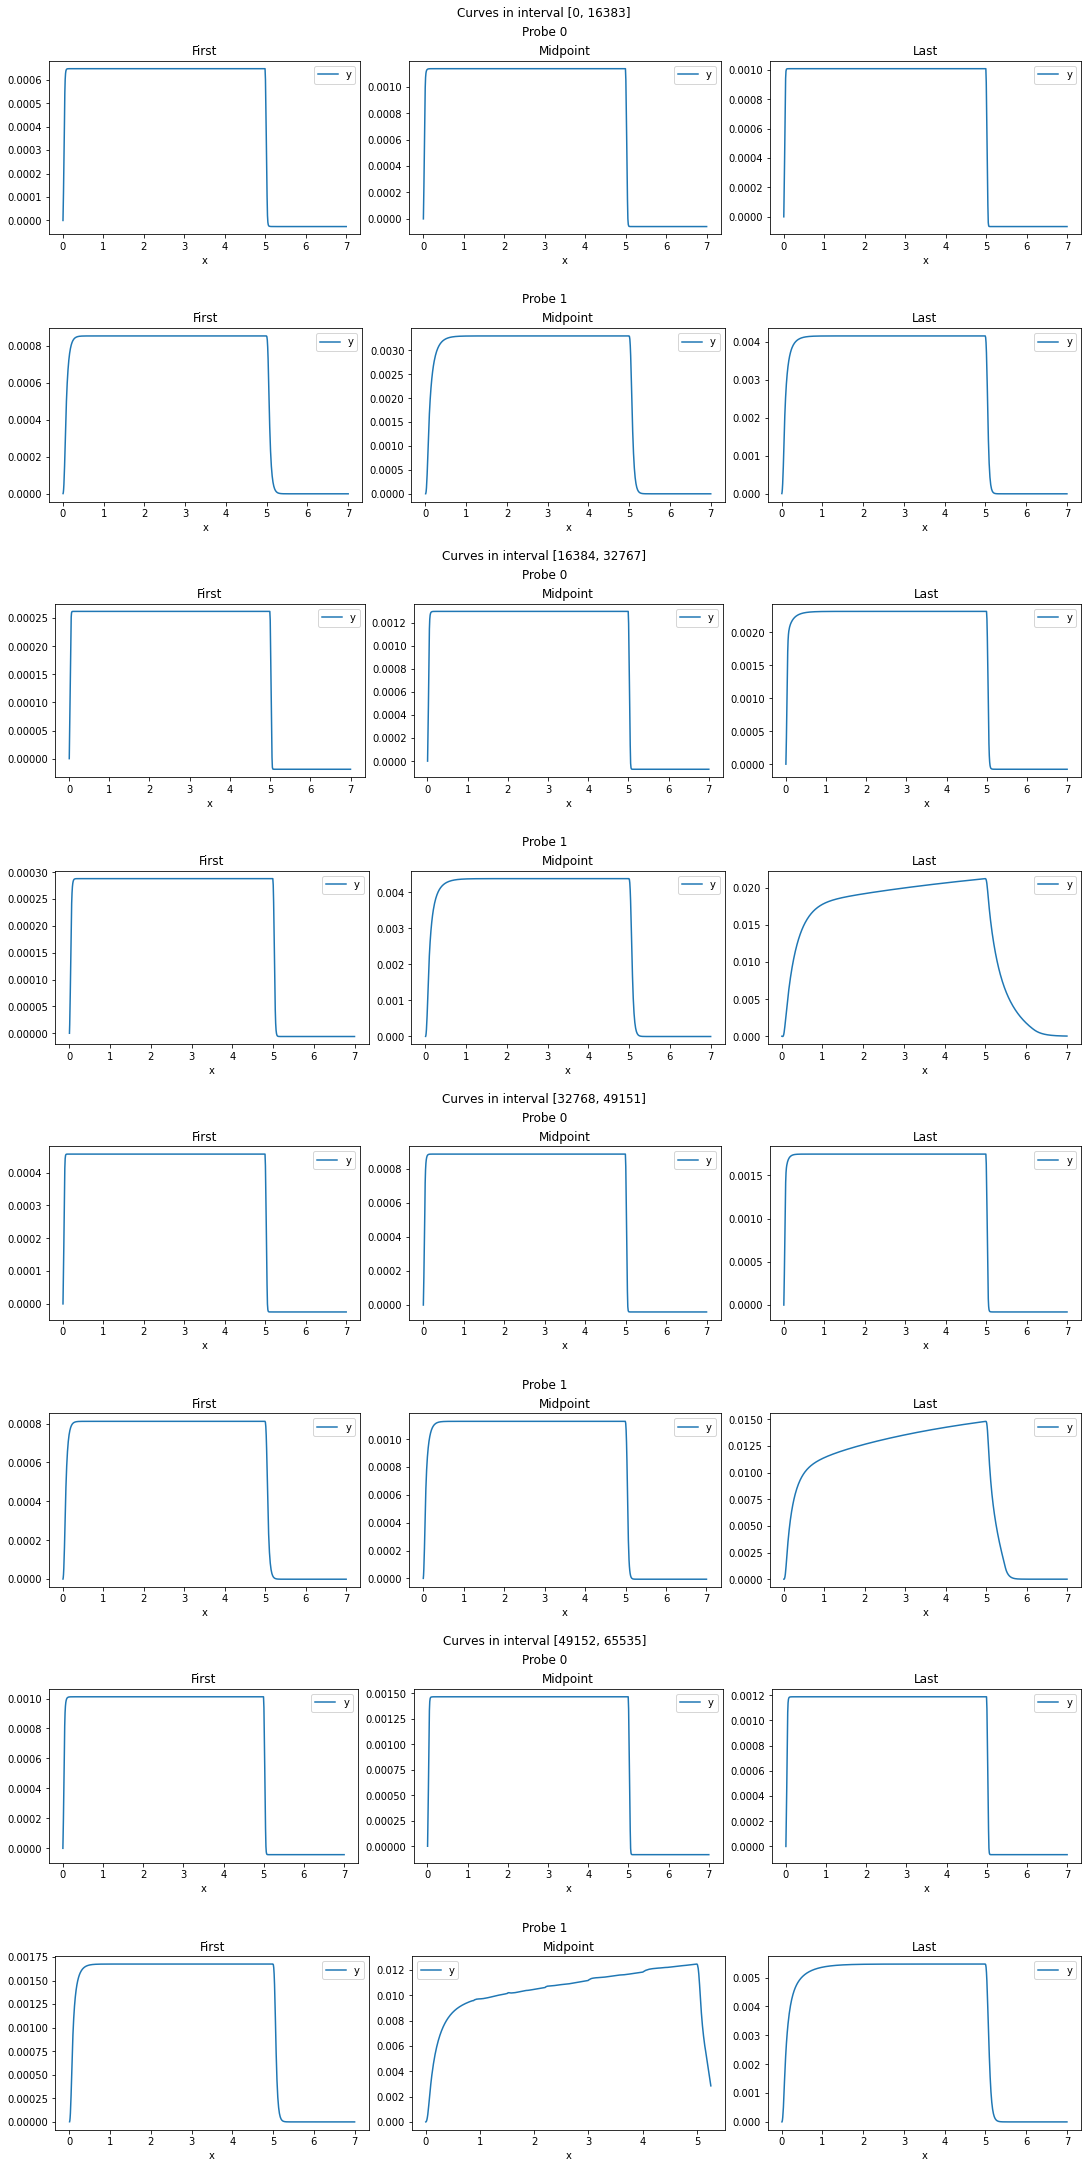

In [99]:
checkSubsets("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl")

In [135]:
def showInvalids(signalFolder):
    probe1_missing = []
    probe2_missing = []
    both_missing = []
    incomplete_1 = []
    incomplete_2 = []
    
    for run in os.listdir(f"{signalFolder}/"):  
        inp = []
        fail = False

        files = os.listdir(f"{signalFolder}/{run}/")

        if 'Disp1.csv' not in files:
            if 'Disp2.csv' not in files:
                both_missing.append(run)
            else:
                probe1_missing.append(run)
            continue
        elif 'Disp2.csv' not in files:
            probe2_missing.append(run)
            continue

        for file in ['Disp1.csv', 'Disp2.csv']:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
            #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)
            if a['x'].max() != 7.0:
                if file == 'Disp1.csv':
                    incomplete_1.append(run)
                else:
                    incomplete_2.append(run)
                    
    print("Exps with both missing:", len(both_missing))
    print("Exps with probe1 missing:", len(probe1_missing))
    print("Exps with probe2 missing:", len(probe2_missing))
    print("Exps with incomplete probe1:", len(incomplete_1))
    print("Exps with incomplete probe2:", len(incomplete_2))
    
    with open(f"missingSamples.pkl", "wb") as f:
            pickle.dump(list(
                set(probe1_missing+probe2_missing+both_missing+incomplete_1+incomplete_2)
            ), f)
            
    print(list(
                set(probe1_missing+probe2_missing+both_missing+incomplete_1+incomplete_2
                   )
            ))
    

In [138]:
with open("missingSamples.pkl", "rb") as f:
            a = pickle.load(f)

In [6]:
with open("statsRes.pkl", "rb") as f:
            a = pickle.load(f)

In [7]:
def getStats(signalFolder, sampleFile):
    me = []
    mse = []
    sse = []
    pts = range(1, 500, 50)

    with open(f"{sampleFile}", "rb") as f:
        samples = pickle.load(f).astype(np.float32)
    print(len(pts))
    for steps in pts:
        x_interped = []
        x_origin = []

        runs = 0
        exps = os.listdir(f"{signalFolder}/")
        exps = [int(exp) for exp in exps]
        random.shuffle(exps)
        exps = exps[:19999]
        print()

        for run in tqdm(exps[:19999]):
            inp = []
            fail = False

            files = os.listdir(f"{signalFolder}/{run}/")

            if files != ['Disp1.csv', 'Disp2.csv']:
                continue



            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                if a['x'].max() != 7.0:
                    failed = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)


                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)

                # Find closest value in original to interpreted
                orig = np.array(a['y'].values)
                closest = []
                for y in interped:

                    diff = []
                    for y_2 in orig:
                        # Get difference
                        diff.append(abs(y_2 - y))

                    # Find location of smallest difference
                    idx = np.array(diff).argmin()
                    # Use as representative point
                    closest.append(orig[idx])


                #fix, ax = plt.subplots(1, 2)
                #ax[0].plot(xNew, interped)
                #a.plot(ax=ax[1], x='x', y='y')
                #if run == 3:
                   # break


                #if len(a) < 702:
                #    print(f"{signalFolder}/{run}/{file}: {len(a)}")
               #     fail = True
                 #   break

               # while len(a) > 702:
                #    a = a.drop(index=np.random.randint(0, len(a)-1)).reset_index(drop=True)

                #print(a)

                x_interped.append(interped.astype(np.float32))
                x_origin.append(closest)
                #print(closest, "\n\n", x_origin)




            if not fail:
                #print(x_origin, "\n", x_interped, "\n", steps)
                mse.append(mean_squared_error(x_origin, x_interped))
                sse.append(mse[-1]*len(x_origin))
                me.append(np.max(np.absolute(np.array(x_origin) - np.array(x_interped))))

    return me, mse, pts, sse


In [37]:
stats = []
with open(f"statsRes.pkl", "rb") as f:
    stats = pickle.load(f)

In [38]:
stats

[[2.617318897435616e-11,
  24710.833214317467,
  26001.69611563166,
  26447.173252396628,
  26672.830389218187,
  26809.16783071286,
  26900.45455632038,
  26965.85360834978,
  27015.009344242335,
  27053.304739832198],
 [3.4176950162714275e-06,
  3226740601.1255746,
  3395301478.7791824,
  3453471883.2979517,
  3482938192.2241106,
  3500741135.3344855,
  3512661355.964315,
  3521201164.178314,
  3527619920.171164,
  3532620532.9272885],
 [0.0001773903836016855,
  83135.5859375,
  87178.8046875,
  88573.4375,
  89279.8046875,
  89706.5546875,
  89992.28125,
  90196.984375,
  90350.8359375,
  90470.6953125],
 451]

In [6]:
import jit

ModuleNotFoundError: No module named 'jit'

In [ ]:
stats = getStats("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl")

10



100%|████████████████████████████████████████████████████████████████████████████| 19999/19999 [09:41<00:00, 34.41it/s]


100%|████████████████████████████████████████████████████████████████████████████| 19999/19999 [54:54<00:00,  6.07it/s]


100%|██████████████████████████████████████████████████████████████████████████| 19999/19999 [1:41:13<00:00,  3.29it/s]


 41%|███████████████████████████████                                            | 8269/19999 [35:21<1:32:43,  2.11it/s]

In [35]:
print(stats)

[[2.617318897435616e-11, 24710.833214317467, 26001.69611563166, 26447.173252396628, 26672.830389218187, 26809.16783071286, 26900.45455632038, 26965.85360834978, 27015.009344242335, 27053.304739832198], [3.4176950162714275e-06, 3226740601.1255746, 3395301478.7791824, 3453471883.2979517, 3482938192.2241106, 3500741135.3344855, 3512661355.964315, 3521201164.178314, 3527619920.171164, 3532620532.9272885], [0.0001773903836016855, 83135.5859375, 87178.8046875, 88573.4375, 89279.8046875, 89706.5546875, 89992.28125, 90196.984375, 90350.8359375, 90470.6953125], 451]


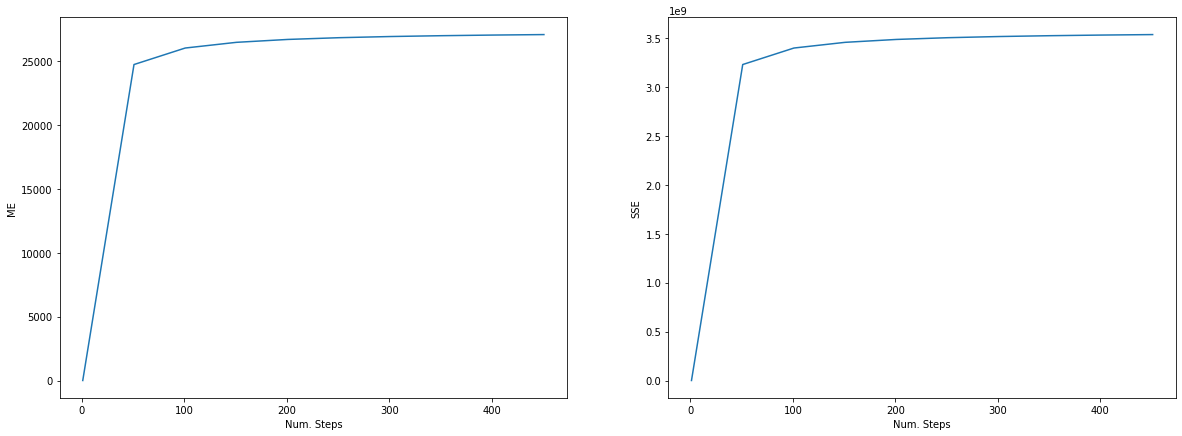

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(range(1, 500, 50), stats[0])
ax[1].plot(range(1, 500, 50), stats[1])
ax[1].set(ylabel="SSE", xlabel="Num. Steps")
ax[0].set(ylabel="ME", xlabel="Num. Steps")
plt.show()
# Check max loss
# Test subsets to restrict

In [9]:
# Folder name will correspond to index of sample
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from torch import tensor
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

class Data(Dataset):
    def __init__(self, signalFolder, sampleFile, steps=128):
        # Load both disp1 and disp2 from each folder
        # Folders ordered according to index of sample
        # Use the corresponding sample as y -> append probe?
        self.input = []
        self.output = []
        
        samples = []
        with open(f"{sampleFile}", "rb") as f:
             samples = pickle.load(f).astype(np.float32)
        
        for run in os.listdir(f"{signalFolder}/"):  
            inp = []
            fail = False
            
            files = os.listdir(f"{signalFolder}/{run}/")
            
            if files != ['Disp1.csv', 'Disp2.csv']:
                continue
            
            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                if a['x'].max() != 7.0:
                    fail = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)
                

                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
                #fix, ax = plt.subplots(1, 2)
                #ax[0].plot(xNew, interped)
                #a.plot(ax=ax[1], x='x', y='y')
                #if run == 3:
                   # break
                
                
                #if len(a) < 702:
                #    print(f"{signalFolder}/{run}/{file}: {len(a)}")
               #     fail = True
                 #   break
                
               # while len(a) > 702:
                #    a = a.drop(index=np.random.randint(0, len(a)-1)).reset_index(drop=True)
                
                #print(a)
                
                a = interped.astype(np.float32)
                inp.append(a)
            
            if not fail:
                if len(inp) != 2:
                    raise Exception("sdf")
                #print(inp[0])
                #raise Exception("sdf")
                self.input.append(tensor(np.array(inp)))
                self.output.append(tensor(samples[int(run)]))    
        
    def __len__(self):
        return len(self.output)
    
    def __getitem__(self, idx):
        sample = {"input": self.input[idx], "output": self.output[idx]}
        return sample

In [22]:
len(dataset)

64486

In [21]:
dataset = Data("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl")

In [11]:
train_n = int(0.8 * len(dataset))
test_n = len(dataset) - train_n
train_set, test_set = torch.utils.data.random_split(dataset, [train_n, test_n])
train_loader, test_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True), DataLoader(test_set, batch_size=32, shuffle=True, pin_memory=True)

In [12]:
DEVICE

device(type='cuda', index=0)

In [53]:
net = CNN1D() #3.01e7 - without batchnorm, 0.5 lr -> 8.69e+6

In [54]:
train(train_loader, net)

Using: cuda:0


Epoch 39/256:  43%|██████████████████▉                         | 703/1633 [00:27<00:36, 25.47batch/s, lastLoss=1.07e+7]


KeyboardInterrupt: 

In [60]:
train(train_loader, net)

Using: cuda:0


Epoch 100/100: 100%|████████████████████████████████████████████| 452/452 [00:04<00:00, 111.67batch/s, lastLoss=4.2e+7]

Average Loss: 102550102.73146021


[206827959.68141592,
 203634531.11504424,
 200488187.46902654,
 197407263.2920354,
 194320932.0,
 191325669.80530974,
 188330912.88495576,
 185413882.44247788,
 182491295.6460177,
 179631429.94690266,
 176804119.32743362,
 173999290.9380531,
 171220302.37168142,
 168484438.88495576,
 165808877.539823,
 163150324.15929204,
 160508251.0619469,
 157894362.99115044,
 155339524.8141593,
 152811371.25663716,
 150311022.97345132,
 147840825.6460177,
 145386472.92035398,
 142970585.94690266,
 140616626.97345132,
 138296477.27433628,
 135971908.15929204,
 133689291.48672566,
 131452585.39823009,
 129233272.84955752,
 127062424.9380531,
 124929999.46902655,
 122822606.81415929,
 120734670.7079646,
 118688791.45132743,
 116677182.01769912,
 114695593.68141593,
 112745725.57522124,
 110823518.38938053,
 108960255.36283186,
 107077899.43362832,
 105259873.7699115,
 103468098.15929204,
 101707301.59292035,
 99985063.11504425,
 98281669.02654867,
 96632758.36283186,
 94976530.56637168,
 93383474.5398

In [27]:
test(test_loader, net)

100%|███████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 353.11 batch/s]

Average Loss: 29596115.111111112
